In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
from bs4 import BeautifulSoup
import re

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://namu.wiki/RecentChanges"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

# 페이지 리스트 가져오기

In [3]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)
            
# 중복 url을 제거합니다
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

https://namu.wiki/w/%ED%8C%8C%EC%9D%BC:conan_v03.jpg
https://namu.wiki/w/%EC%8B%A0%EA%B8%B8%EB%8F%99(%EC%84%9C%EC%9A%B8)
https://namu.wiki/w/%EB%A7%88%EB%A6%AC%EC%86%94%20%EA%B3%A4%EC%9E%98%EB%A0%88%EC%8A%A4
https://namu.wiki/w/%EC%8B%B1%ED%98%B8
https://namu.wiki/w/%EB%B3%B4%EC%84%B1%EA%B3%A0%EB%93%B1%ED%95%99%EA%B5%90(%EC%84%9C%EC%9A%B8)


# 페이지 내 텍스트 구조 확인

In [4]:
req = requests.get(page_urls[0])
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name = 'article')
title = contents_table.find_all('h1')[0]
category = contents_table.find_all('ul')[0]
content_paragraphs = contents_table.find_all(name="div", attrs={"class" : "wiki-paragraph"})
content_corpus_list = []

for paragraphs in content_paragraphs:
    content_corpus_list.append(paragraphs.text)
content_corpus = "".join(content_corpus_list)

print(title.text)
print("\n")
print(category.text)
print("\n")
print(content_corpus)

파일:conan_v03.jpg 


파일/만화


이 파일은 나무위키에서 제한된 한도 안에서 쓰입니다.본 이미지는 퍼블릭 도메인 혹은 자유이용 저작물이 아닌, 독점적 저작권이 존재하는 이미지입니다. 나무위키는 본 이미지를 제한된 한도 안에서 이용합니다.※ 다음과 같은 사항을 참조하시기 바랍니다.권리자는 해당 이미지가 나무위키에 게시되어 권리자의 정당한 권리를 침해한다고 여겨진다면 문의 게시판에 문의해 주세요.해당 이미지를 업로드한 사용자는 자신의 행위에 대한 법적 책임이 부과될 수 있음을 숙지해 주세요.권리자는 해당 이미지가 나무위키에 게시되어 권리자의 정당한 권리를 침해한다고 여겨진다면 문의 게시판에 문의해 주세요.해당 이미지를 업로드한 사용자는 자신의 행위에 대한 법적 책임이 부과될 수 있음을 숙지해 주세요.1. 기본 정보2. 이미지 설명출처출처를 반드시 삽입해 주세요.날짜이미지가 만들어진 날짜를 삽입해 주세요.저작자이미지의 저작자를 삽입해 주세요.저작권이미지의 저작권과 관련된 기타 정보를 삽입해 주세요.기타기타 정보가 있으면 삽입해 주세요.이미지의 자세한 설명을 적어 주세요.


# 나무위키 최근 변경 데이터 크롤링

In [5]:
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우를 확인합니다.
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
    
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
        
        
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
        
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 "분류"라는 단어와 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""

    # 모든 정보를 하나의 데이터프레임에 저장합니다
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)

In [6]:
df.head()

,title,category,content_text
0,파일:conan_v03.jpg,파일/만화,이 파일은 나무위키에서 제한된 한도 안에서 쓰입니다.본 이미지는 퍼블릭 도메인 혹은...
1,신길동(서울),영등포구의 법정동,⠀서울특별시 영등포구⠀행정구역 [ 펼치기 · 접기 ]당산동당산동1가당산동2가구청 당...
2,마리솔 곤잘레스,오렌지 이즈 더 뉴 블랙,이 문서에 스포일러가 포함되어 있습니다.이 문서가 설명하는 작품이나 인물 등에 대한...
3,싱호,한국 남성 코미디언/ㅅ유튜버/ㅅ1989년 출생부산광역시 출신 인물유튜브 크리에이터 ...,인덕대 방송연예과 출신 개그유튜버 멤버 전원이 인덕대학교 방송연예과 출신인 경우에만...
4,보성고등학교(서울),남자고등학교서울특별시의 고등학교동성학원1906년 개교,"이 문서는 학교 관련 문서이며, 회원만 수정 가능합니다. 다음과 같은 서술은 작성 ..."


# 키워드 추출
## [텍스트 데이터 전처리]

In [7]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다
def text_cleaning(text):
    hangul = re.compile('[^ㄱ-ㅣ가-힣]+') #  한글의 정규표현식을 나타냅니다
    result = hangul.sub('', text)
    return result

In [8]:
print(text_cleaning(df['title'][0]))

파일


## 말뭉치 만들기

In [9]:
# 각 피처마다 말뭉치를 생성합니다.
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())

title_corpus

'파일:conan_v03.jpg 신길동(서울) 마리솔 곤잘레스 싱호 보성고등학교(서울) 공매도 대림동 샤오룽 Xbox/역사 MBC 무브먼트 WMV 타노스(마블 시네마틱 유니버스)/능력 2021년 미국 국회의사당 점거 폭동 타키야마 신호장 제드송 페르난데스 심장에박현서 송사비 비에고 스핏파이어(던전 앤 파이터)/여자/스킬 안현모 드림 리그 사커 2021 무직전생 ~이세계에 갔으면 최선을 다한다~/애니메이션 Bad North 파일:conan_v04.jpg I.B.I 불로불사 몰컴/은폐와 탐지 트랜스여성 카미조 하루카 해나(뮤지컬 배우)/미스터리 음악쇼 복면가왕 웨이브 더 스왈로 트로피컬 루즈! 프리큐어 OMORI 메탈슬러그 XX 캐치! 티니핑/티니핑 김치 こじまつり〜小嶋陽菜感謝祭〜 실버(포켓몬스터) 점박이(한반도의 공룡 시리즈) 모험가(던전 앤 파이터) Blackhawk Rescue Mission 5/무기 슬기로운 의사생활 수학Ⅰ(2015) 사이먼 피어슨 한국 Fate/Grand Order 2021년 근하신년 스타트 대시 캠페인 중단 사태 막시밀리안 1세(신성 로마 제국) 카미조 타츠히사 도림동(서울) 스티븐 비건 빌보드 핫 100 라비던스 전위(삼국지톡) IZ*ONE/커버곡 울라불라 블루짱 로만 폴란스키 asked 패트릭 맥리어리 인민민주주의 신현준 석주일 문래동 C.I.V.A HEXCELLS 시리즈 파일:conan_v02.jpg 축구 야구 말구 강상수 신비한 TV 서프라이즈/에피소드/2004년 프리드로우(웹툰)/등장인물 규진 오늘은 이만 물러가주지 코쵸우 시노부 오주희 코로나바이러스감염증-19/현황 2020년 미국 양원·주지사 선거 마우저 C96 젯 더 호크 틀:서울특별시의 마을버스/은평구 서머너즈 워 : 천공의 아레나/몬스터 일람/바람 속성 민우혁 성찬(NCT) 1월 5일 김치녀 '

In [10]:
!pip install konlpy

In [11]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출합니다
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)
count

Counter({'이': 1483,
         '파일': 14,
         '나무': 42,
         '위키': 25,
         '제한': 82,
         '한도': 6,
         '안': 375,
         '이미지': 125,
         '퍼블릭': 3,
         '도메인': 3,
         '자유': 29,
         '이용': 146,
         '저작물': 3,
         '독점': 32,
         '저작권': 10,
         '존재': 217,
         '다음': 177,
         '사항': 415,
         '참조': 51,
         '권리자': 12,
         '해당': 194,
         '게시': 31,
         '권리': 15,
         '침해': 7,
         '문의': 14,
         '게시판': 10,
         '업로드': 24,
         '사용자': 17,
         '자신': 783,
         '행위': 33,
         '대한': 313,
         '법적': 15,
         '책임': 31,
         '부과': 7,
         '수': 1782,
         '음': 60,
         '숙지': 7,
         '기본': 392,
         '정보': 95,
         '설명': 103,
         '출처': 16,
         '반드시': 40,
         '삽입': 18,
         '날짜': 55,
         '저작자': 6,
         '관련': 145,
         '기타': 98,
         '서울특별시': 50,
         '영등포구': 75,
         '행정구역': 13,
         '접기': 122,
        

## [키워드 가다듬기]


In [12]:
# 한글자 키워드를 제거
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'문서': 2188, '이전': 2116, '문단': 2112, '역사': 1980, '공격': 1593, '스킬': 1242, '때문': 882, '자신': 783, '경우': 717, '사용': 644, '효과': 632, '이후': 605, '사람': 589, '증가': 570, '김치': 544, '정도': 518, '다른': 511, '체력': 479, '토론': 447, '시간': 444, '사항': 415, '합의': 412, '쿨타임': 410, '속도': 402, '게임': 401, '레벨': 400, '기본': 392, '확률': 382, '거짓': 376, '방어': 375, '이름': 370, '하나': 370, '이야기': 365, '모든': 363, '미국': 362, '각성': 361, '주인공': 350, '시작': 342, '모습': 337, '방송': 333, '위해': 328, '이상': 326, '사실': 324, '리더': 318, '대한': 313, '등장': 312, '피해': 312, '또한': 309, '상태': 305, '다시': 303, '상황': 299, '추가': 296, '진실': 296, '가장': 295, '기술': 294, '모두': 293, '아군': 293, '내용': 288, '생각': 288, '모험가': 279, '사건': 276, '가지': 267, '턴간': 264, '대상': 262, '트럼프': 248, '다만': 247, '상대': 245, '특성': 244, '한국': 242, '현재': 241, '타입': 239, '이유': 236, '유저': 234, '최대': 229, '자체': 228, '배치': 222, '문제': 220, '존재': 217, '당시': 215, '적용': 213, '강화': 210, '본인': 208, '매우': 206, '통해': 206, '전체': 202, '도구': 202, '처음': 200, '진행': 197, '영상': 197, '

### 불용어 제거

In [13]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "./data/korean_stopwords.txt"

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [14]:
# 나무위키 페이지에 맞는 불용어를 추가합니다.
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [15]:
# 키워드 데이터에서 불용어를 제거합니다.
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'이전': 2116, '문단': 2112, '역사': 1980, '공격': 1593, '스킬': 1242, '효과': 632, '사람': 589, '증가': 570, '김치': 544, '체력': 479, '토론': 447, '사항': 415, '합의': 412, '쿨타임': 410, '속도': 402, '게임': 401, '레벨': 400, '기본': 392, '확률': 382, '거짓': 376, '방어': 375, '이야기': 365, '미국': 362, '각성': 361, '주인공': 350, '시작': 342, '방송': 333, '위해': 328, '리더': 318, '대한': 313, '등장': 312, '피해': 312, '상태': 305, '다시': 303, '진실': 296, '기술': 294, '아군': 293, '모험가': 279, '사건': 276, '가지': 267, '턴간': 264, '대상': 262, '트럼프': 248, '상대': 245, '특성': 244, '한국': 242, '현재': 241, '타입': 239, '이유': 236, '유저': 234, '최대': 229, '자체': 228, '배치': 222, '문제': 220, '존재': 217, '당시': 215, '적용': 213, '강화': 210, '본인': 208, '통해': 206, '전체': 202, '도구': 202, '처음': 200, '진행': 197, '영상': 197, '능력': 194, '부분': 192, '음악': 191, '일부': 190, '학년': 190, '시리즈': 187, '코로나': 186, '감소': 184, '몬스터': 181, '속성': 180, '공매도': 179, '한태성': 177, '멤버': 176, '사랑': 176, '시브': 174, '지금': 173, '일본': 173, '여성': 173, '데미지': 172, '기절': 171, '마스터': 170, '보고': 169, '마법': 169, '고등학교'

In [25]:
import random
import pytagcloud
import webbrowser

# 가장 출현 빈도수가 높은 40개의 단어를 선정합니다.
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는 80으로 제한합니다.
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

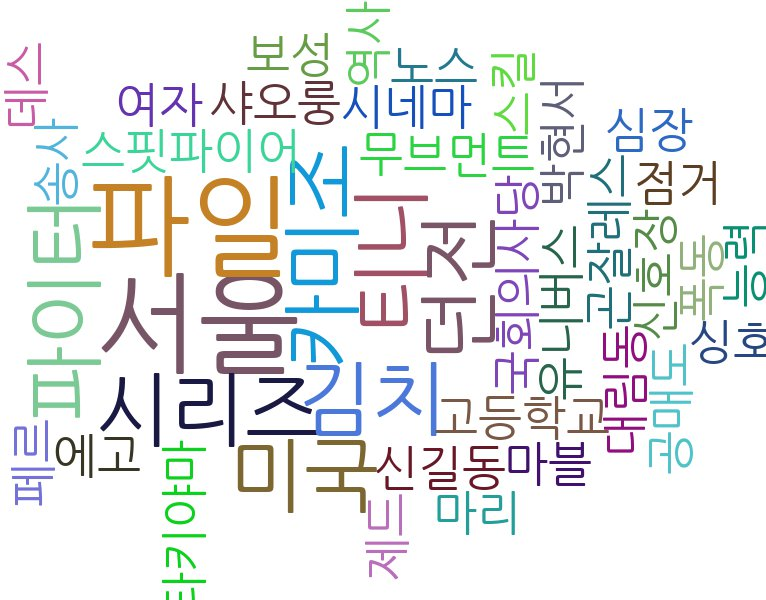

In [26]:
# 생성한 이미지를 주피터 노트북상에서 출력합니다.
from IPython.display import Image
Image(filename='wordcloud.jpg')

## [나무위키 키워드 시각화]

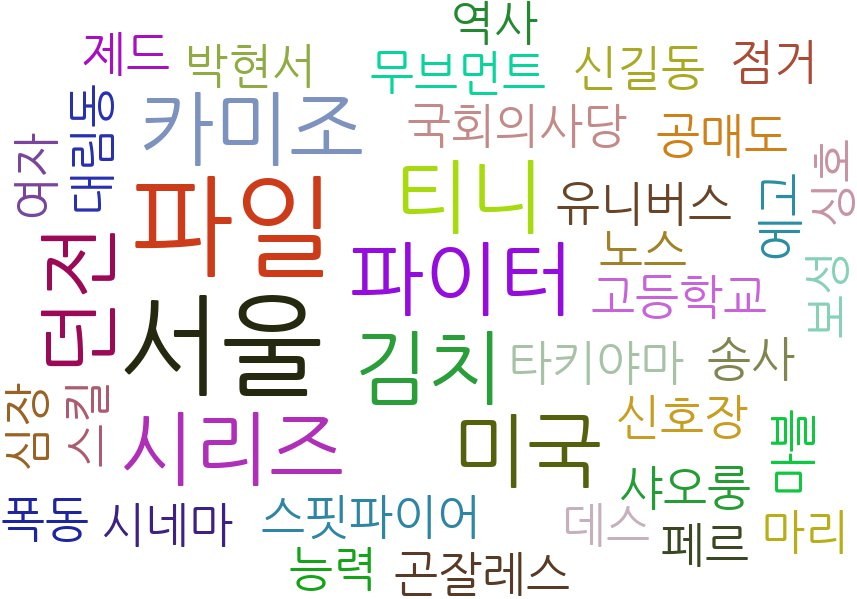

In [27]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

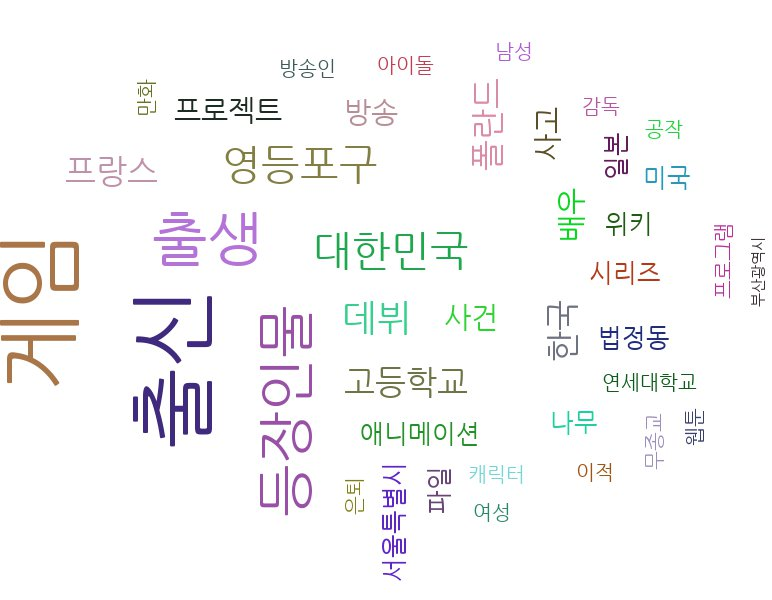

In [35]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')